

# Decoding (MVPA)

## Design philosophy
Decoding (a.k.a. MVPA) in MNE largely follows the machine learning API of the
scikit-learn package.
Each estimator implements:
 * ``fit``
 * ``transform``
 * ``fit_transform``, and
 * (optionally) ``inverse_transform`` methods. 
 
For more details on this design, visit scikit-learn_. For additional theoretical insights into the decoding
framework in MNE :footcite:`KingEtAl2018`.

For ease of comprehension, we will denote instantiations of the class using
the same name as the class but in small caps instead of camel cases.

Let's start by loading data for a simple two-class problem:

# Preparing the data

In [97]:
import mne
from mne.datasets import sample

data_path = sample.data_path()

subjects_dir = data_path / "subjects"
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"

raw = mne.io.read_raw_fif(raw_fname)

Opening raw data file /Users/mainak/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.


We will select gradiometers, keep the trigger channels for epoching, and EOG to remove blinks

In [98]:
raw.pick(picks=["grad", "stim", "eog"]);

# Set up bad channels (modify to your needs)
raw.info["bads"] += ["MEG 2443"]  # bads + 2 more

## Filter

The subsequent decoding analyses only capture evoked responses, so we can low-pass the MEG data. Usually a value more like 40 Hz would be used,but here low-pass at 20 so we can more heavily decimate, and allow
the example to run faster. The 2 Hz high-pass helps improve CSP.

In [99]:
raw.load_data().filter(2, 20)

Reading 0 ... 41699  =      0.000 ...   277.709 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 2 - 20 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Upper passband edge: 20.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 22.50 Hz)
- Filter length: 249 samples (1.658 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.1s
[Parallel(n_jobs=1)]: Done 161 tasks      | elapsed:    0.1s


Measurement date,"December 03, 2002 19:01:10 GMT"
Experimenter,Unknown
Participant,Unknown
Digitized points,146 points
Good channels,"203 Gradiometers, 9 Stimulus, 1 EOG"
Bad channels,"MEG 2443, MEG 2443"
EOG channels,EOG 061
ECG channels,Not available
Sampling frequency,150.15 Hz
Highpass,2.00 Hz
Lowpass,20.00 Hz


In [100]:
events = mne.find_events(raw, "STI 014")

tmin, tmax = -0.200, 0.500
event_id = {"Auditory/Left": 1, "Visual/Left": 3}  # just use two

# Read epochs
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=("grad", "eog"),
    baseline=(None, 0.0),
    preload=True,
    reject=dict(grad=4000e-13, eog=150e-6),
    decim=3,
    verbose="error",
)
epochs.pick(picks="meg", exclude="bads")  # remove stim and EOG
del raw

X = epochs.get_data(copy=False)  # MEG signals: n_epochs, n_meg_channels, n_times
y = epochs.events[:, 2]  # target: auditory left vs visual left

319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


# A basic decoder

First make the classifier:

In [101]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

from mne.decoding import Vectorizer, Scaler

In [102]:
clf = make_pipeline(
    Scaler(epochs.info),
    Vectorizer(),
    LogisticRegression(solver="liblinear"),  # liblinear is faster than lbfgs
)

Uses all MEG sensors and time points as separate classification features, so the resulting filters used are spatio-temporal

Now score:

In [103]:
from mne.decoding import cross_val_multiscore
    
scores = cross_val_multiscore(clf, X, y, cv=5, n_jobs=None)

# Mean scores across cross-validation splits
score = np.mean(scores, axis=0)
print(f"Spatio-temporal: {100 * score:0.1f}%")

Spatio-temporal: 99.2%


## Transformation classes

### Scaler

* `scalings=None` or ``scalings=dict(...)``,
each data channel type (e.g., mag, grad, eeg) is treated separately and
scaled by a constant.
* ``scalings='mean'`` or ``scalings='median'``, each channel is scaled independently using
empirical measures
* `scaler.transform()` scales all time points
and epochs on a channel-by-channel basis. 
* To perform both the ``fit`` and
``transform`` operations in a single call, the
:meth:`~mne.decoding.Scaler.fit_transform` method may be used
* mne.decoding.Scaler.inverse_transform` to invert transform

# Exercise

How is `sklearn.preprocessing.StandardScaler` different from `mne.decoding.Scaler`?

In [104]:
# your answer here

### Vectorizer

* Scikit-learn API provides functionality to chain transformers and estimators
by using `sklearn.pipeline.Pipeline`
* Pipeline helps cross-validation and grid-search
* BUT: scikit-learn expects 2D data
* Vectorizer takes (n_samples * n_channels * n_frequencies * n_times) into (n_sample * n_features)

### PSDEstimator
`mne.decoding.PSDEstimator`
computes the power spectral density (PSD) using the multitaper
method. It takes a 3D array as input, converts it into 2D and computes the
PSD.

### FilterEstimator
Filters the 3D epochs data.

## Spatial filters

Just like temporal filters, spatial filters provide weights to modify the
data along the sensor dimension. They are popular in the BCI community
because of their simplicity and ability to distinguish spatially-separated
neural activity.

### Common spatial pattern

:class:`mne.decoding.CSP` is a technique to analyze multichannel data based
on recordings from two classes :footcite:`Koles1991` (see also
https://en.wikipedia.org/wiki/Common_spatial_pattern).



Let $X \in R^{C\times T}$ be a segment of data with
$C$ channels and $T$ time points. The data at a single time point
is denoted by $x(t)$ such that $X=[x(t), x(t+1), ..., x(t+T-1)]$.
Common spatial pattern (CSP) finds a decomposition that projects the signal
in the original sensor space to CSP space using the following transformation:

\begin{align}x_{CSP}(t) = W^{T}x(t)
   :name: csp\end{align}

where each column of $W \in R^{C\times C}$ is a spatial filter and each
row of $x_{CSP}$ is a CSP component. The matrix $W$ is also
called the de-mixing matrix in other contexts. Let
$\Sigma^{+} \in R^{C\times C}$ and $\Sigma^{-} \in R^{C\times C}$
be the estimates of the covariance matrices of the two conditions.
CSP analysis is given by the simultaneous diagonalization of the two
covariance matrices

\begin{align}W^{T}\Sigma^{+}W = \lambda^{+}
   :name: diagonalize_p\end{align}
\begin{align}W^{T}\Sigma^{-}W = \lambda^{-}
   :name: diagonalize_n\end{align}

where $\lambda^{C}$ is a diagonal matrix whose entries are the
eigenvalues of the following generalized eigenvalue problem

\begin{align}\Sigma^{+}w = \lambda \Sigma^{-}w
   :name: eigen_problem\end{align}

Large entries in the diagonal matrix corresponds to a spatial filter which
gives high variance in one class but low variance in the other. Thus, the
filter facilitates discrimination between the two classes.

.. topic:: Examples

    * `ex-decoding-csp-eeg`
    * `ex-decoding-csp-eeg-timefreq`

<div class="alert alert-info"><h4>Note</h4><p>The winning entry of the Grasp-and-lift EEG competition in Kaggle used
    the :class:`~mne.decoding.CSP` implementation in MNE and was featured as
    a [script of the week](sotw_).</p></div>


We can use CSP with these data with:



In [105]:
from mne.decoding import CSP, LinearModel

In [106]:
csp = CSP(n_components=3, norm_trace=False)
clf_csp = make_pipeline(csp, LinearModel(LogisticRegression(solver="liblinear")))
scores = cross_val_multiscore(clf_csp, X, y, cv=5, n_jobs=None)
print(f"CSP: {100 * scores.mean():0.1f}%")

Computing rank from data with rank=None
    Using tolerance 6e-11 (2.2e-16 eps * 203 dim * 1.3e+03  max singular value)
    Estimated rank (data): 203
    data: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6e-11 (2.2e-16 eps * 203 dim * 1.3e+03  max singular value)
    Estimated rank (data): 203
    data: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 6e-11 (2.2e-16 eps * 203 dim * 1.3e+03  max singular value)
    Estimated rank (data): 203
    data: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating class=1 covarian

### Source power comodulation (SPoC)
Source Power Comodulation (`mne.decoding.SPoC`)
:footcite:`DahneEtAl2014` identifies the composition of
orthogonal spatial filters that maximally correlate with a continuous target.

SPoC can be seen as an extension of the CSP where the target is driven by a
continuous variable rather than a discrete variable. Typical applications
include extraction of motor patterns using EMG power or audio patterns using
sound envelope.

.. topic:: Examples

    * `ex-spoc-cmc`

### xDAWN
:class:`mne.preprocessing.Xdawn` is a spatial filtering method designed to
improve the signal to signal + noise ratio (SSNR) of the ERP responses
:footcite:`RivetEtAl2009`. Xdawn was originally
designed for P300 evoked potential by enhancing the target response with
respect to the non-target response. The implementation in MNE-Python is a
generalization to any type of ERP.

.. topic:: Examples

    * `ex-xdawn-denoising`
    * `ex-xdawn-decoding`

### Effect-matched spatial filtering
The result of :class:`mne.decoding.EMS` is a spatial filter at each time
point and a corresponding time course :footcite:`SchurgerEtAl2013`.
Intuitively, the result gives the similarity between the filter at
each time point and the data vector (sensors) at that time point.

.. topic:: Examples

    * `ex-ems-filtering`

### Patterns vs. filters

When interpreting the components of the CSP (or spatial filters in general),
it is often more intuitive to think about how $x(t)$ is composed of
the different CSP components $x_{CSP}(t)$. In other words, we can
rewrite Equation :eq:`csp` as follows:

\begin{align}x(t) = (W^{-1})^{T}x_{CSP}(t)
   :name: patterns\end{align}

The columns of the matrix $(W^{-1})^T$ are called spatial patterns.
This is also called the mixing matrix. 

These can be plotted with:

Computing rank from data with rank=None
    Using tolerance 6.6e-11 (2.2e-16 eps * 203 dim * 1.5e+03  max singular value)
    Estimated rank (data): 203
    data: rank 203 computed from 203 data channels with 0 projectors
Reducing data rank from 203 -> 203
Estimating class=1 covariance using EMPIRICAL
Done.
Estimating class=3 covariance using EMPIRICAL
Done.


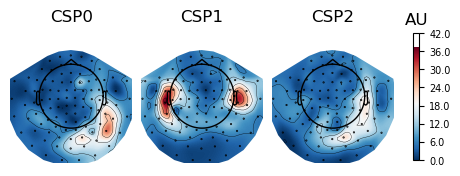

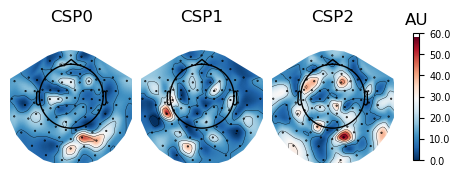

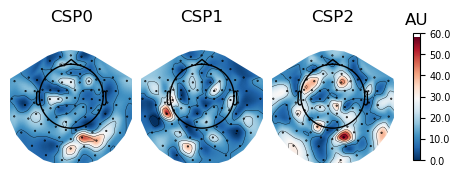

In [107]:
# Fit CSP on full data and plot
csp.fit(X, y)
csp.plot_patterns(epochs.info)
csp.plot_filters(epochs.info, scalings=1e-9)

The example `ex-linear-patterns`
discusses the difference between patterns and filters.


## Decoding over time

This strategy consists in fitting a multivariate predictive model on each
time instant and evaluating its performance at the same instant on new
epochs. The class `mne.decoding.SlidingEstimator` will take as input a
pair of features $X$ and targets $y$, where $X$ has
more than 2 dimensions. For decoding over time the data $X$
is the epochs data of shape n_epochs × n_channels × n_times. As the
last dimension of $X$ is the time, an estimator will be fit
on every time instant.

This approach is analogous to SlidingEstimator-based approaches in fMRI,
where here we are interested in when one can discriminate experimental
conditions and therefore figure out when the effect of interest happens.

When working with linear models as estimators, this approach boils
down to estimating a discriminative spatial filter for each time instant.

### Temporal decoding

We'll use a Logistic Regression for a binary classification as machine
learning model.

In [108]:
import numpy as np

from mne.decoding import SlidingEstimator

In [109]:
# We will train the classifier on all left visual vs auditory trials on MEG

clf = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)
# here we use cv=3 just for speed
scores = cross_val_multiscore(time_decod, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

Text(0.5, 1.0, 'Sensor space decoding')

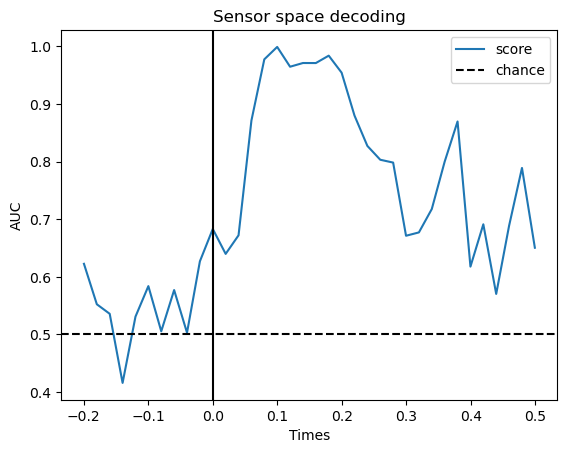

In [110]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(epochs.times, scores, label="score")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlabel("Times")
ax.set_ylabel("AUC")  # Area Under the Curve
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Sensor space decoding")

You can retrieve the spatial filters and spatial patterns if you explicitly
use a LinearModel



  0%|          | Fitting SlidingEstimator : 0/36 [00:00<?,       ?it/s]

No projector specified for this dataset. Please consider the method self.add_proj.


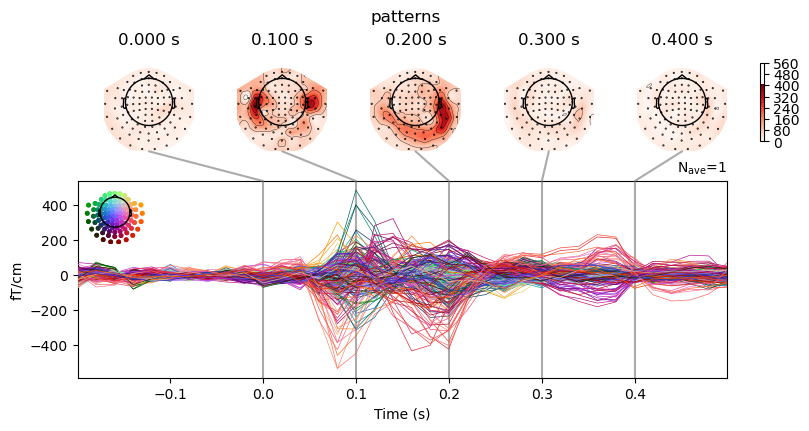

In [74]:
clf = make_pipeline(
    StandardScaler(), LinearModel(LogisticRegression(solver="liblinear"))
)
time_decod = SlidingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)
time_decod.fit(X, y)

coef = get_coef(time_decod, "patterns_", inverse_transform=True)
evoked_time_gen = mne.EvokedArray(coef, epochs.info, tmin=epochs.times[0])
joint_kwargs = dict(ts_args=dict(time_unit="s"), topomap_args=dict(time_unit="s"))
evoked_time_gen.plot_joint(
    times=np.arange(0.0, 0.500, 0.100), title="patterns", **joint_kwargs
);

### Temporal generalization

Temporal generalization is an extension of the decoding over time approach.
It consists in evaluating whether the model estimated at a particular
time instant accurately predicts any other time instant. It is analogous to
transferring a trained model to a distinct learning problem, where the
problems correspond to decoding the patterns of brain activity recorded at
distinct time instants.

The object to for Temporal generalization is
:class:`mne.decoding.GeneralizingEstimator`. It expects as input $X$
and $y$ (similarly to :class:`~mne.decoding.SlidingEstimator`) but
generates predictions from each model for all time instants. The class
:class:`~mne.decoding.GeneralizingEstimator` is generic and will treat the
last dimension as the one to be used for generalization testing. For
convenience, here, we refer to it as different tasks. If $X$
corresponds to epochs data then the last dimension is time.

This runs the analysis used in :footcite:`KingEtAl2014` and further detailed
in :footcite:`KingDehaene2014`:



In [84]:
from mne.decoding import GeneralizingEstimator

In [76]:
# define the Temporal generalization object
time_gen = GeneralizingEstimator(clf, n_jobs=None, scoring="roc_auc", verbose=True)

# again, cv=3 just for speed
scores = cross_val_multiscore(time_gen, X, y, cv=3, n_jobs=None)

# Mean scores across cross-validation splits
scores = np.mean(scores, axis=0)

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

  0%|          | Fitting GeneralizingEstimator : 0/36 [00:00<?,       ?it/s]

  0%|          | Scoring GeneralizingEstimator : 0/1296 [00:00<?,       ?it/s]

Text(0.5, 1.0, 'Decoding MEG sensors over time')

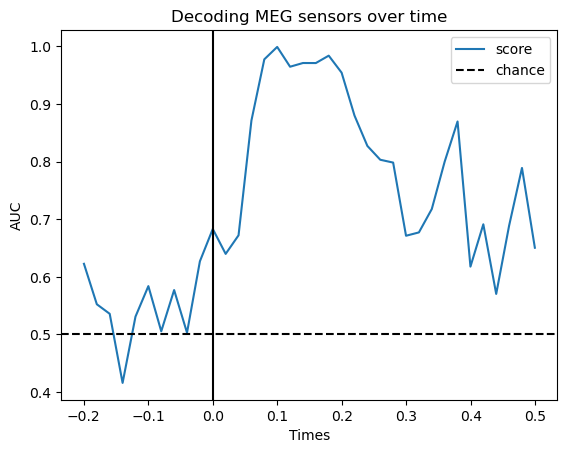

In [77]:
# Plot the diagonal (it's exactly the same as the time-by-time decoding above)
fig, ax = plt.subplots()
ax.plot(epochs.times, np.diag(scores), label="score")
ax.axhline(0.5, color="k", linestyle="--", label="chance")
ax.set_xlabel("Times")
ax.set_ylabel("AUC")
ax.legend()
ax.axvline(0.0, color="k", linestyle="-")
ax.set_title("Decoding MEG sensors over time")

Plot the full (generalization) matrix:



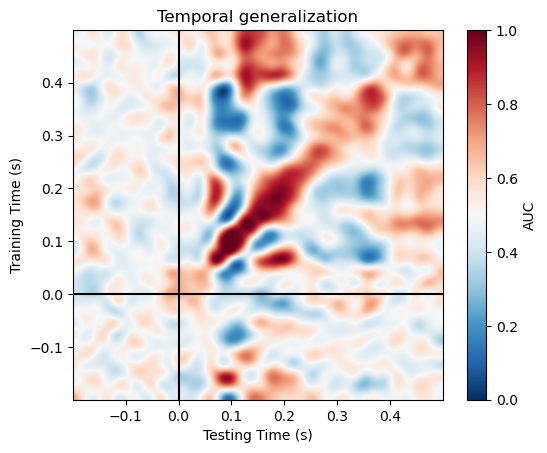

In [78]:
fig, ax = plt.subplots(1, 1)
im = ax.imshow(
    scores,
    interpolation="lanczos",
    origin="lower",
    cmap="RdBu_r",
    extent=epochs.times[[0, -1, 0, -1]],
    vmin=0.0,
    vmax=1.0,
)
ax.set_xlabel("Testing Time (s)")
ax.set_ylabel("Training Time (s)")
ax.set_title("Temporal generalization")
ax.axvline(0, color="k")
ax.axhline(0, color="k")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("AUC")

## Projecting sensor-space patterns to source space
If you use a linear classifier (or regressor) for your data, you can also
project these to source space. For example, using our ``evoked_time_gen``
from before:



In [79]:
cov = mne.compute_covariance(epochs, tmax=0.0)
del epochs
fwd = mne.read_forward_solution(meg_path / "sample_audvis-meg-eeg-oct-6-fwd.fif")
inv = mne.minimum_norm.make_inverse_operator(evoked_time_gen.info, fwd, cov, loose=0.0)
stc = mne.minimum_norm.apply_inverse(evoked_time_gen, inv, 1.0 / 9.0, "dSPM")
del fwd, inv

Reducing data rank from 203 -> 203
Estimating covariance using EMPIRICAL
Done.
Number of samples used : 1353
[done]
Reading forward solution from /Users/mainak/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Forward solutions combined: MEG, EEG
    Source spaces transformed to the forward solution coordinate frame
Computing inverse operator with 203 channels.
    203 out of 366 channels remain after 

And this can be visualized using :meth:`stc.plot <mne.SourceEstimate.plot>`:



In [80]:
brain = stc.plot(
    hemi="split", views=("lat", "med"), initial_time=0.1, subjects_dir=subjects_dir
)

Using pyvistaqt 3d backend.

Using control points [1.98776221 2.41838256 8.06628582]


qt.qpa.fonts: Populating font family aliases took 497 ms. Replace uses of missing font family "Menlo" with one that exists to avoid this cost. 


## Source-space decoding

Source space decoding is also possible, but because the number of features
can be much larger than in the sensor space, univariate feature selection
using ANOVA f-test (or some other metric) can be done to reduce the feature
dimension. Interpreting decoding results might be easier in source space as
compared to sensor space.

.. topic:: Examples

    * `ex-dec-st-source`

## Exercise

 - Explore other datasets from MNE (e.g. Face dataset from SPM to predict
   Face vs. Scrambled)

## References
.. footbibliography::

